<a href="https://colab.research.google.com/github/patrickabadi/gen-ai-notebooks/blob/main/clip_metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CLIP Metadata

Using OpenAI's CLIP model to classify a group of images in order to generate properties

In [16]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
#@title Setup
!pip3 install tqdm
!pip3 install git+https://github.com/openai/CLIP.git

import clip
import torch
import os
import json

from IPython.display import display
from PIL import Image
from os import listdir
from os.path import isfile, join
from pathlib import Path
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def rank(model, image_features, text_array, top_count=1):
    top_count = min(top_count, len(text_array))
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = torch.zeros((1, len(text_array))).to(device)
    for i in range(image_features.shape[0]):
        similarity += (100.0 * image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)
    similarity /= image_features.shape[0]

    top_probs, top_labels = similarity.cpu().topk(top_count, dim=-1)  
    return [(text_array[top_labels[0][i].numpy()], (top_probs[0][i].numpy()*100)) for i in range(top_count)]

def classify(model, image_features, show_output):

  attributes = []

  for key,values in classifiers.items():

    val, confidence = rank(model, image_features, values)[0]

    attrib = {
        "trait_type": key,
        "value": val
    }

    attributes.append(attrib)

    if show_output:
      print(f"{key} = {val} with confidence {confidence}")

  return attributes





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ofi3es4i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ofi3es4i
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


## Classifiers

Enter one or more classifier groups to run the data through


In [19]:
classifiers = {
  "elements": [        
    "flower","cosmic","bloom","magic","lightning","glow","crown","furry","feathers","vivid colors","clouds","fluffy","horns"
  ],
  "animal": [
      "serpent","turtle","badger","spider","bug","penguin","starfish","camel","jellyfish","seal","octopus","owl","porcupine","racoon","unknown","rabbit","ferret","frog","tiger","lion","leopard gecko","lizard","bird","panda","fox","marmmot","wolf","eel","mouse","bear","hawk","rhinoceros","hippopotamus","kangaroo","elephant","bull","yak","bee","bat","ant"
  ],
  "color": [
      "Navy","Olive","Maroon","Magenta","Yellow","Orange","Orchid","Silver","Sky Blue","Snow","Teal","Thistle","Turquoise","Violet","White","Sienna","Pink","Purple","Red","Salmon","Lavender","Cyan","Dark Magenta","Dark Green","Dark Gray","Dark Cyan","Dark Blue","Ivory","Crimson","Coral","Chartreuse","Brown","Blue","Black","Beige","Azure","Aquamarine","Aqua","Indigo","Green","Gray","Gold","Fuchsia","Violet"
  ]  
}

  0%|          | 0/4 [00:00<?, ?it/s]

open image file /content/gdrive/MyDrive/art/example_animals/fantastical-0569.png


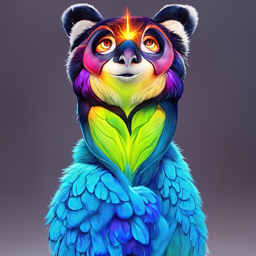

 25%|██▌       | 1/4 [00:00<00:01,  1.50it/s]

elements = furry with confidence 43.617960810661316
animal = ferret with confidence 34.97684895992279
color = Indigo with confidence 74.01328682899475
open image file /content/gdrive/MyDrive/art/example_animals/fantastical-0122.png


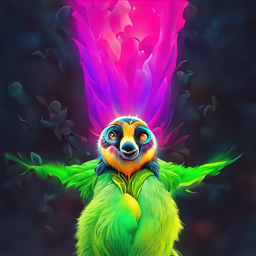

 50%|█████     | 2/4 [00:01<00:01,  1.64it/s]

elements = glow with confidence 47.50577509403229
animal = ferret with confidence 21.753045916557312
color = Indigo with confidence 38.86944651603699
open image file /content/gdrive/MyDrive/art/example_animals/fantastical-0639.png


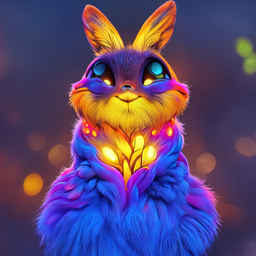

 75%|███████▌  | 3/4 [00:01<00:00,  1.67it/s]

elements = vivid colors with confidence 36.968547105789185
animal = rabbit with confidence 64.67788815498352
color = Indigo with confidence 35.90087592601776
open image file /content/gdrive/MyDrive/art/example_animals/fantastical-0473.png


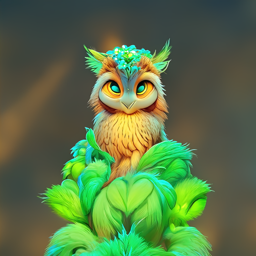

100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

elements = feathers with confidence 40.338775515556335
animal = owl with confidence 98.38346242904663
color = Cyan with confidence 35.863348841667175


In [24]:
#@title Run batch
#@markdown `input_folder`: subfolder where images are stored<br>
#@markdown `show_verbose_output`: show image thumbnails and print results<br>
#@markdown `description`: optional description to add to json ouput<br>

input_folder = "/content/gdrive/MyDrive/art/example_animals" #@param {type:"string"}
show_verbose_output = True #@param{type:"boolean"}
description = "This is my story" #@param {type:"string"}

if input_folder == "":
  raise ValueError("`input_folder` is not set properly")


files = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]

if len(files) == 0:
  raise ValueError(f"No files found in {input_folder}")


model, preprocess = clip.load('ViT-L/14')
model.cuda().eval()

metadata = []

for file in tqdm(files):
  path = join(input_folder, file)
  print(f"open image file {path}")
  
  image = Image.open(path).convert('RGB')

  if show_verbose_output:
    thumb = image.copy()
    thumb.thumbnail([256, 256])
    display(thumb) 

  images = preprocess(image).unsqueeze(0).cuda()
  with torch.no_grad():
      image_features = model.encode_image(images).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)

  attributes = classify(model, image_features, show_verbose_output)

  mtitem = {
      "name": Path(path).stem,
      "description": description,
      "attributes": attributes
  }

  metadata.append(mtitem)


In [25]:
#@title JSON output

print(json.dumps(metadata, indent=1))

[
 {
  "name": "fantastical-0569",
  "description": "This is my story",
  "attributes": [
   {
    "trait_type": "elements",
    "value": "furry"
   },
   {
    "trait_type": "animal",
    "value": "ferret"
   },
   {
    "trait_type": "color",
    "value": "Indigo"
   }
  ]
 },
 {
  "name": "fantastical-0122",
  "description": "This is my story",
  "attributes": [
   {
    "trait_type": "elements",
    "value": "glow"
   },
   {
    "trait_type": "animal",
    "value": "ferret"
   },
   {
    "trait_type": "color",
    "value": "Indigo"
   }
  ]
 },
 {
  "name": "fantastical-0639",
  "description": "This is my story",
  "attributes": [
   {
    "trait_type": "elements",
    "value": "vivid colors"
   },
   {
    "trait_type": "animal",
    "value": "rabbit"
   },
   {
    "trait_type": "color",
    "value": "Indigo"
   }
  ]
 },
 {
  "name": "fantastical-0473",
  "description": "This is my story",
  "attributes": [
   {
    "trait_type": "elements",
    "value": "feathers"
   },
   {
